<a href="https://colab.research.google.com/github/vickyskarthik/DL_PyTorch/blob/master/final_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POC Demonstration
## DATASET             : The Oxford-IIIT Pet Dataset 
## TASK                : semantic segmentation
## ARCHITECTURE        : UNet11
## ENCODER WEIGHTS     : VGG 
## Install the required libraries

In [27]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

Images are successfully downloaded


In [28]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.5.2 is successfully installed


In [29]:
!pip install ternausnet > /dev/null

In [30]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
cudnn.benchmark = True
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2


## MODEL INITIALIZATION AND ARCHITECTURE

In [31]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import models

def conv3x3(in_: int, out: int) -> nn.Module:
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int) -> None:
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(
        self, in_channels: int, middle_channels: int, out_channels: int
    ) -> None:
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(
                middle_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters: int = 32, pretrained: bool = False) -> None:
        """
        Args:
            num_filters:
            pretrained:
                False - no pre-trained network is used
                True  - encoder is pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg11(pretrained=pretrained).features

        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(
            num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8
        )
        self.dec5 = DecoderBlock(
            num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8
        )
        self.dec4 = DecoderBlock(
            num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4
        )
        self.dec3 = DecoderBlock(
            num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2
        )
        self.dec2 = DecoderBlock(
            num_filters * (4 + 2), num_filters * 2 * 2, num_filters
        )
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)


class Interpolate(nn.Module):
    def __init__(
        self,
        size: int = None,
        scale_factor: int = None,
        mode: str = "nearest",
        align_corners: bool = False,
    ):
        super().__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.interp(
            x,
            size=self.size,
            scale_factor=self.scale_factor,
            mode=self.mode,
            align_corners=self.align_corners,
        )
        return x


class DecoderBlockV2(nn.Module):
    def __init__(
        self,
        in_channels: int,
        middle_channels: int,
        out_channels: int,
        is_deconv: bool = True,
    ):
        super().__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(
                    middle_channels, out_channels, kernel_size=4, stride=2, padding=1
                ),
                nn.ReLU(inplace=True),
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode="bilinear"),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class UNet11(nn.Module):
    def __init__(
        self,
        num_classes: int = 1,
        num_filters: int = 32,
        pretrained: bool = False,
        is_deconv: bool = False,
    ):
        """
        Args:
            num_classes:
            num_filters:
            pretrained:
                False - no pre-trained network used
                True - encoder pre-trained with VGG16
            is_deconv:
                False: bilinear interpolation is used in decoder
                True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(
            self.encoder[0], self.relu, self.encoder[2], self.relu
        )

        self.conv2 = nn.Sequential(
            self.encoder[5], self.relu, self.encoder[7], self.relu
        )

        self.conv3 = nn.Sequential(
            self.encoder[10],
            self.relu,
            self.encoder[12],
            self.relu,
            self.encoder[14],
            self.relu,
        )

        self.conv4 = nn.Sequential(
            self.encoder[17],
            self.relu,
            self.encoder[19],
            self.relu,
            self.encoder[21],
            self.relu,
        )

        self.conv5 = nn.Sequential(
            self.encoder[24],
            self.relu,
            self.encoder[26],
            self.relu,
            self.encoder[28],
            self.relu,
        )

        self.center = DecoderBlockV2(
            512, num_filters * 8 * 2, num_filters * 8, is_deconv
        )

        self.dec5 = DecoderBlockV2(
            512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv
        )
        self.dec4 = DecoderBlockV2(
            512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv
        )
        self.dec3 = DecoderBlockV2(
            256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv
        )
        self.dec2 = DecoderBlockV2(
            128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv
        )
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)

## HELPER FUNCTION
## 1. TO DISPLAY PROGRESS
## 2. TO DOWNLOAD DATABASE
## 3. TO UNZIP THE FILES

In [32]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Dataset already exists on the disk. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

## ASSIGNING  A DIRECTORY TO DOWNLOAD **DATASET**

In [33]:
dataset_directory = os.path.join("datasets/oxford-iiit-pet")

## **DOWNLOAD THE OXFORD PET DATASET- CLEANED**

In [34]:
filepath = os.path.join(dataset_directory, "images.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
)
extract_archive(filepath)

Dataset already exists on the disk. Skipping download.


In [35]:
filepath = os.path.join(dataset_directory, "annotations.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
)
extract_archive(filepath)

Dataset already exists on the disk. Skipping download.


## **INITIALIZING DATASET DIRECTORY & SPLITTING INTO TRAIN, VAL AND TEST**

In [36]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:6000]
val_images_filenames = correct_images_filenames[6000:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

6000 1374 10


## INITIALIZING A BINARY MASK

In [37]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

## **PREPARING FOR DATASET TRAVERSAL**

In [38]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

##**INITIALIZING THE TRANSFORM FOR TRAINING AND VALIDATION**

In [39]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

##**FUNCTION TO MEASURE TRAINING AND VALIDATION LOSS**

In [40]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

##**TRAINING & VALIDATION FUNCTION**

In [41]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [42]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

##**CREATING THE UNET MODEL WITH PRETRAINED VGG ENCODER**

In [43]:
def create_model(params):
    model = getattr(ternausnet.models, params["model"])(pretrained=True)
    model = model.to(params["device"])
    return model

## **FUNCTION TO TRAIN AND VALIDATRE**

In [44]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

##**FUNCTION TO PREDICT**

In [45]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

##**MODEL PARAMETERS**

In [46]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

In [47]:
import ternausnet.models
model = create_model(params)

## TRAINING THE MODEL

In [48]:
model = train_and_validate(model, train_dataset, val_dataset, params)

Streaming output truncated to the last 5000 lines.
Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 137/375 [01:49<03:09,  1.26it/s]

Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 137/375 [01:50<03:09,  1.26it/s]

Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 138/375 [01:50<03:09,  1.25it/s]

Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 138/375 [01:51<03:09,  1.25it/s]

Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 139/375 [01:51<03:09,  1.25it/s]

Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 139/375 [01:51<03:09,  1.25it/s]

Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 140/375 [01:51<03:07,  1.25it/s]

Epoch: 8. Train.      Loss: 0.163:  37%|███▋      | 140/375 [01:52<03:07,  1.25it/s]

Epoch: 8. Train.      Loss: 0.163:  38%|███▊      | 141/375 [01:52<03:06,  1.26it/s]

Epoch: 8. Train.      Loss: 0.163:  38%|███▊      | 141/375 [01:53<03:06,  1.26it/s]

Epoch: 8. Train.      Loss: 0.163:  38%|███▊      | 142/375 [01:53<03:06,  1.25it/s]

Epo

##**SAVING THE TRAINED MODEL- STATE & ENTIRE MODEL**

In [55]:
# Specify a path
PATH = os.path.join(dataset_directory, "state_dict_model.pt")

# Save
torch.save(model.state_dict(), PATH)

# Load
# model = model()
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [56]:
# Specify a path
PATH1 = os.path.join(dataset_directory, "entire_model.pt")

# Save
torch.save(model, PATH1)

# Load
testmodel = torch.load(PATH1)
testmodel.eval()

UNet11(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)

##INFERENCE FUNCTION FOR TESTING

In [57]:
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

## TEST TRANSFORM

In [58]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [59]:
predictions = predict(model, params, test_dataset, batch_size=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [61]:
import albumentations.augmentations.functional as F
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = F.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

In [62]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

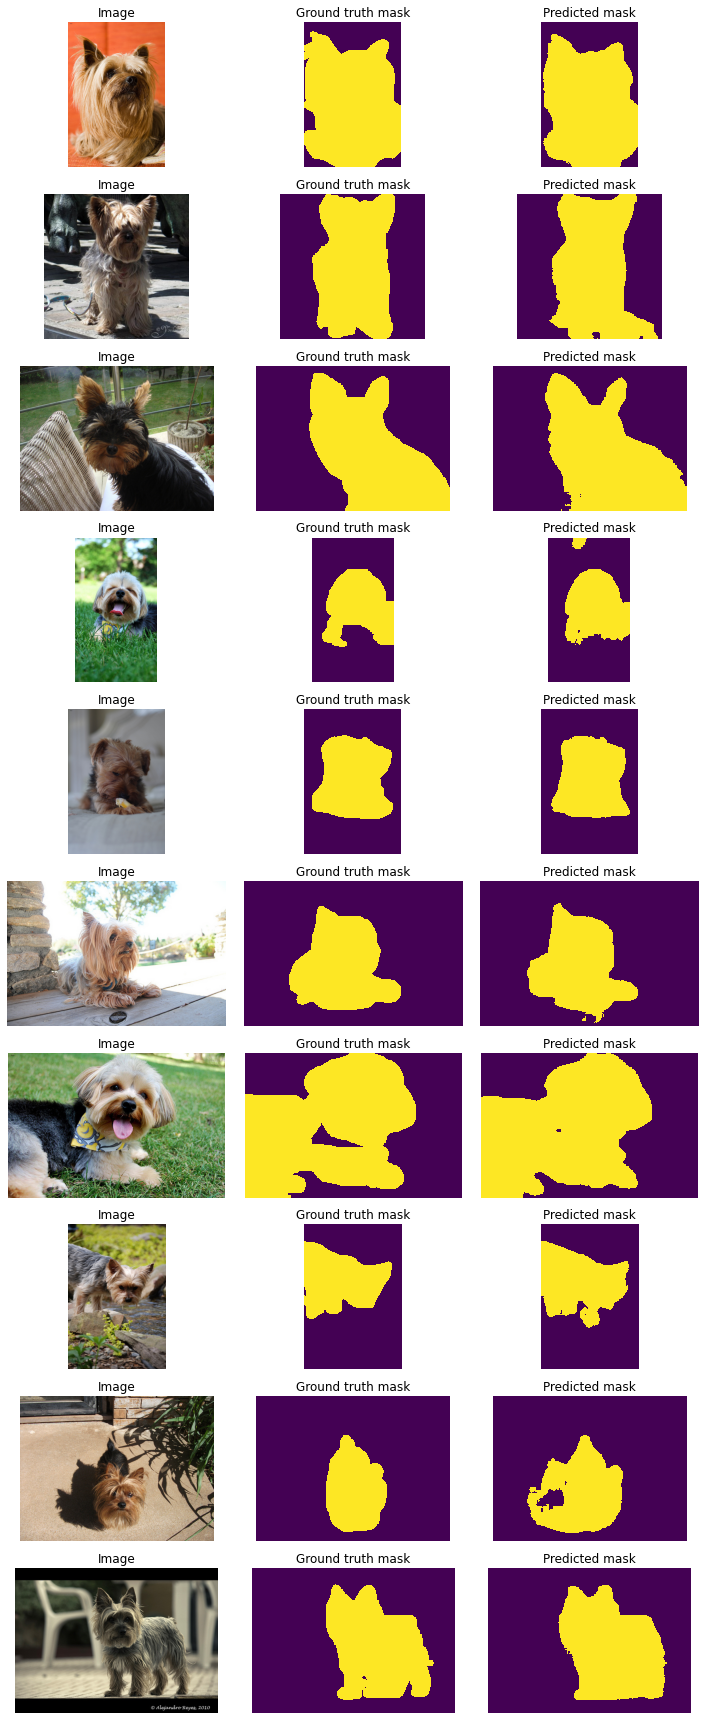

In [63]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)